# Bluring Faces

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/bluring-faces.ipynb)

Click the `Open in Colab` button to run the cookbook on Google Colab.

## Introduction

In this cookbook we'll use a frame from a video of someone in a supermarket. We'll download this video via the `supervision` assets submodule. We'll then run inference on this frame using the hosted roboflow api to fetch detections of faces utilizing an open source face detection model on roboflow universe. Finally, we'll use supervision to blur the detected faces.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Feb 19 13:41:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install packages

Let's quickly install the `supervision` package with the assets submodule, as well as the roboflow `inference_sdk` with pip. We'll also install `tqdm` to show a progress bar, but this is optional in production code.

In [5]:
!pip3 install -q "supervision[assets]" inference_sdk tqdm

## Download Video and Extract Frame

In order to blur a face in a frame, we'll need a frame with a face in it. Let's download a video, and grab a frame in the middle of the video. I played around a little, and found that the 800th frame is great frame for us to test, since the customer is facing the camera. In this code, we're also using tqdm to display a progress bar of our script.

grocery-store.mp4 asset download complete. 



100%|██████████| 800/800 [00:41<00:00, 19.30it/s]


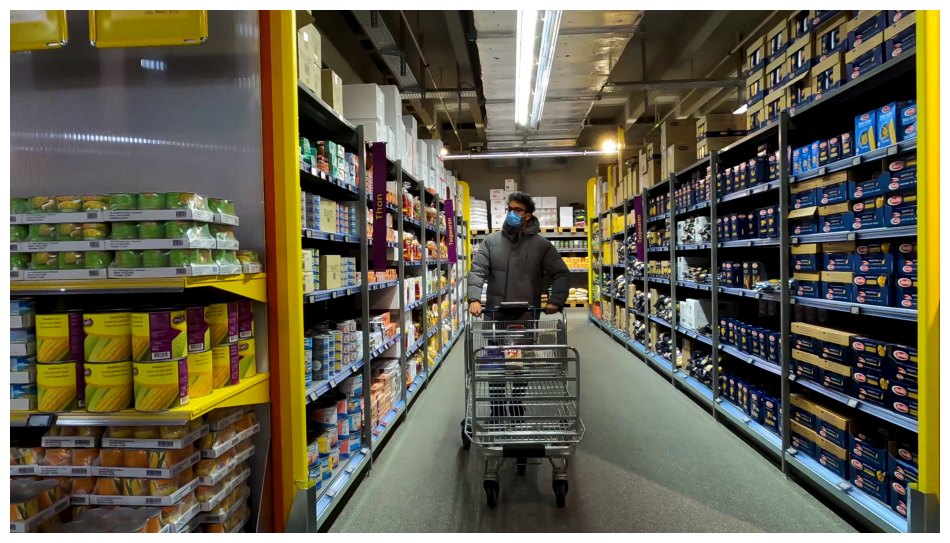

In [6]:

from supervision.assets import download_assets, VideoAssets
import supervision as sv
from tqdm import tqdm

video = download_assets(VideoAssets.GROCERY_STORE)

video_frames = sv.get_video_frames_generator(video)

for i in tqdm(range(800)):
  frame = next(video_frames)

sv.plot_image(frame)


## Detecting Faces

Now that we've got our image we'll need a good face detecting model. For this task, there are already an impressive amount of open source models available on [Roboflow Universe](https://universe.roboflow.com/). After a little digging, this [face detection model](https://universe.roboflow.com/mohamed-traore-2ekkp/face-detection-mik1i) has over 1300 images. Some models, including this one, require a Roboflow API key. You can [create a free account here](https://app.roboflow.com/login). From there, you can find the key under Settings > Workspaces > Roboflow API. Let's give it a try.

In [7]:
from inference_sdk import InferenceHTTPClient

roboflow_api_key = "" # Replace this string with your Roboflow Private API Key

client = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key=roboflow_api_key
)

results = client.infer(frame, model_id="face-detection-mik1i/18")

print(results)

{'time': 0.13854728899968904, 'image': {'width': 3840, 'height': 2160}, 'predictions': [{'x': 2094.375, 'y': 838.125, 'width': 131.25, 'height': 161.25, 'confidence': 0.8007787466049194, 'class': 'face', 'class_id': 0, 'detection_id': '9d68ab64-2e03-4800-a5ed-5a794f70e6da'}]}


## Bluring the Face

Now that we're detecting faces, bluring them is easy with supervision. Let's pass our results into a `Detections` object and annotate the frame with a `BlurAnnotator`.

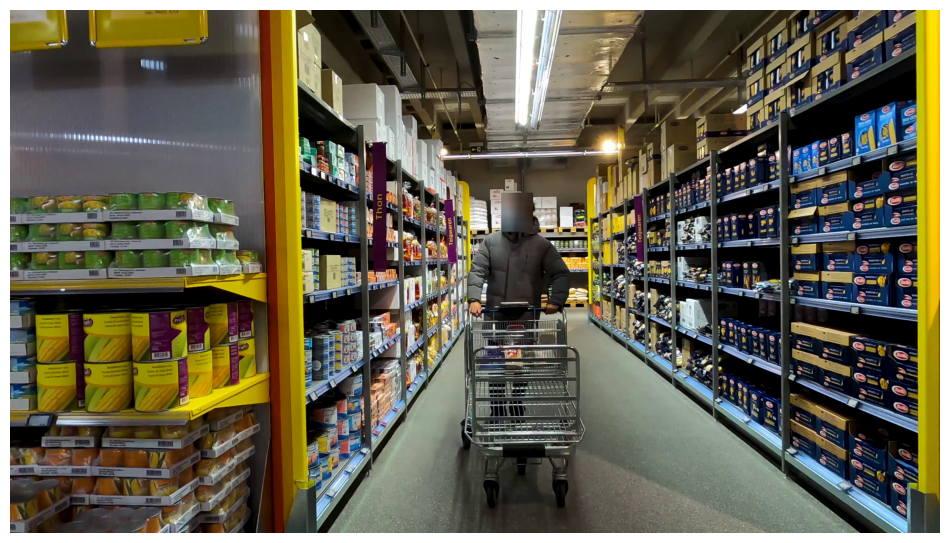

In [9]:

blur = sv.BlurAnnotator(kernel_size=100)

detections = sv.Detections.from_inference(results)

annotated_frame = blur.annotate(scene=frame.copy(), detections=detections)

sv.plot_image(annotated_frame)

# Conclusion

With supervision, inference, and roboflow universe we were able to blur faces in minutes with an open source model. There are many other impressive use cases out there, so feel free to share in your own cookbooks. Happy building!